# Designing the JuliaCon 2019 T-shirt

## Cormullion and David P. Sanders

We offered to design some graphics for the JuliaCon 2019 T-shirt. Several ideas were proposed, and were received variously with “meh” or “cool”, and there was much enjoyable bike-shedding. Eventually, a design derived from the [Penrose tiling](https://en.wikipedia.org/wiki/Penrose_tiling) was developed, using Julia code.

In this notebook we explain some of the steps in arriving at the final design.

The basic drawing was made using [Luxor.jl](https://github.com/JuliaGraphics/Luxor.jl), and the algorithms for resolving the colouring used [SimpleGraphs]( https://github.com/scheinerman/SimpleGraphs.jl).

## Penrose tilings

A Penrose tiling is a tiling (covering) of the plane using two particular tile types:

[FIG of tile types]

The surprising thing is that the tiling turns out to be *quasiperiodic*: it never repeats itself, but does "almost repeat itself".

A common method to produce Penrose tilings is the method of **inflation&ndash;deflation**: we start with a given set of tiles and recursively replace each tile with a certain combination of smaller tiles.

![recursive division](recursion.svg)

In this implementation, we build everything out of triangles, represented by the following `struct`. 
Here, `A`, `B` and `C` are the 3 points in the triangle, `Point` is a type from `Luxor` representing the coordinates of a point in 2D, and `flag` is a Boolean variable representing the "type" of triangle.

In [1]:
using Luxor

struct Triangle
    flag::Bool 
    A::Point
    B::Point
    C::Point
end

┌ Info: Recompiling stale cache file /Users/pete/.julia/compiled/v1.1/Luxor/HA9ps.ji for Luxor [ae8d54c2-7ccd-5906-9d76-62fc9837b5bc]
└ @ Base loading.jl:1184


We start by generating $n$ triangles in a circle with center $c$ and radius $r$. The `polar` function generates a vector with given radius and angle

In [2]:
function initialize(center::Point, n)
    A = center
    r = 100
    triangles = Triangle[]
    for i in 1:n
        ϕ = (i - 1) * (2π / n)
        C = A + polar(r, ϕ)
        
        ϕ = (i) * (2π / n)
        B = A + polar(r, ϕ)
        
        if i % 2 == 1
            triangle = Triangle(true, B, A, C)
        else
            triangle = Triangle(true, C, A, B)
        end
        
        push!(triangles, triangle)
    end
    
    return triangles
end

initialize (generic function with 1 method)

Let's draw these triangles. For now we can just apply a polygon-drawing function `poly()` to the points. (And we're currently working in global scope, which you'll want to be aware of.)

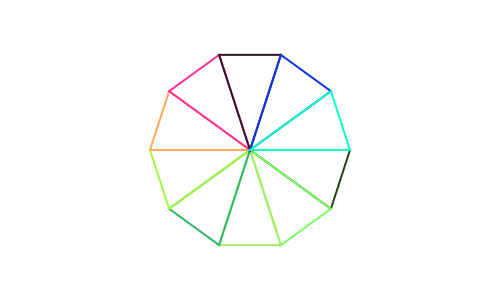

In [22]:
@svg begin
    for triangle in initialize(O, 10)
        randomhue()
        poly([triangle.A, triangle.B, triangle.C], close=true, :stroke)
    end
end 500 300 "figure1"

Now we subdivide recursively using the following function:

In [4]:
function subdivide(triangles::Vector{Triangle})
    
    result = Triangle[]
    
    for triangle in triangles
        A, B, C = triangle.A, triangle.B, triangle.C

        if triangle.flag
            Q = A + (B - A) / MathConstants.golden
            R = B + (C - B) / MathConstants.golden
            
            push!(result, Triangle(false, R, Q, B))
            push!(result, Triangle(true,  Q, A, R))
            push!(result, Triangle(true,  C, A, R))

        else           
            P = C + (A - C) / MathConstants.golden
            
            push!(result, Triangle(false, B, P, A))
            push!(result, Triangle(true,  P, C, B))
        end
    end
    
    return result
end

subdivide (generic function with 1 method)

Let's see the result of a single subdivisions.

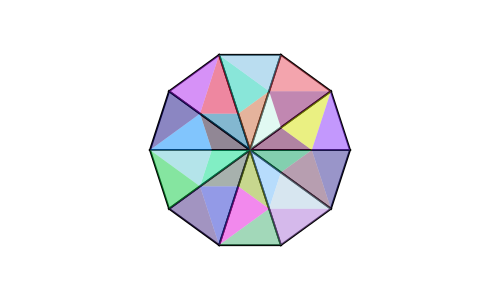

In [5]:
@svg begin
    initialtriangles = initialize(O, 10)
    
    for triangle in initialtriangles
        poly([triangle.A, triangle.B, triangle.C], close=true, :stroke)
    end
    
    triangles = subdivide(initialtriangles)

    setopacity(0.5)
    
    for triangle in triangles
        randomhue()
        poly([triangle.A, triangle.B, triangle.C], close=true, :fill)
    end
end 500 300 "figure2"

In [6]:
If you repeat the subdivision, you quickly build up a rich pattern.

LoadError: syntax: extra token "you" after end of expression

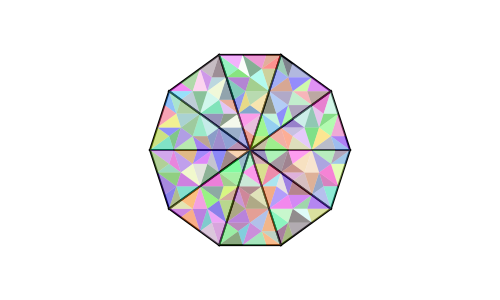

In [7]:
@svg begin
    initialtriangles = initialize(O, 10)
    
    for triangle in initialtriangles
        poly([triangle.A, triangle.B, triangle.C], close=true, :stroke)
    end
    
    triangles = subdivide(initialtriangles)
    triangles = subdivide(triangles)
    triangles = subdivide(triangles)

    setopacity(0.5)
    
    for triangle in triangles
        randomhue()
        poly([triangle.A, triangle.B, triangle.C], close=true, :fill)
    end
    end 500 300 "figure3"

This provides the basis for our Penrose-inspired design.

## Colouring the triangles

A Penrose tiling can be thought of as a planar map, and the [Four-colour Theorem](https://en.wikipedia.org/wiki/Four_color_theorem) says that any map of the plane can be coloured using at most 4 colours. Here, a map colouring is one in which neighbouring "countries" are coloured by different colours if they are joined by an edge (not just a point).

Since there are 4 colours in the Julia logo, we decided to find the perfect colouring of our Penrose tiling using the Julia colours!

### Mapping to a graph

To do so, we think of the collection of triangles as a **graph** or **network**, i.e. a collection of vertices joined by edges. We need to find the **adjacency matrix** of the graph, i.e. a matrix $A_{ij}$ which contains $1$ if nodes $i$ and $j$ are connected, and $0$ if they are not connected.

The problem is that the inflation&ndash;deflation method that we are using to construct the triangles gives us no information about which triangles are neighbours (at least, we are not aware of how to directly extract this information from the construction).

Hence, the first thing to do is to extract the adjacency matrix, for which we just use brute force: given two triangles, we calculate the distances between each of their vertices. If exactly two of these distances are (approximately) zero, then those two vertices coincide, and hence the two triangles share an edge:

In [16]:
using SimpleGraphs

function incidence_matrix(triangles::Vector{Triangle})

    n = length(triangles)

    g = IntGraph(n)

    for i in 1:n
        for j in i+1:n
            ti = triangles[i]
            tj = triangles[j]

            points_i = [ti.A, ti.B, ti.C]
            points_j = [tj.A, tj.B, tj.C]

            coincidental = 0
            tol = 1e-2

            for k in 1:3, l in 1:3
                if distance(points_i[k], points_j[l]) < tol
                    coincidental += 1
                end
            end

            if coincidental == 2  # share edge
                add!(g, i, j)
            end
        end
    end

    return g
end

incidence_matrix (generic function with 1 method)

In [17]:
g = incidence_matrix(triangles)

SimpleGraph{Int64} (n=210, m=300)

FIGURE OF THE GRAPH SUPERIMPOSED ON THE TRIANGLES: JOIN THE CENTROID OF ADJACENT TRIANGLES WITH A LINE

In [21]:
vlist(g)

210-element Array{Int64,1}:
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
  12
  13
   ⋮
 199
 200
 201
 202
 203
 204
 205
 206
 207
 208
 209
 210

### Colouring the graph

Finally, we want to find a **graph colouring** with the property that adjacent nodes do not share the same colour. This is accomplished by 

In [9]:
g = incidence_matrix(triangles)

colouring = greedy_color(g, [1:n;])

ErrorException: type Triangle has no field pointA

It turns out that for the Penrose tiling, there are rather few nodes that use the fourth colour (i.e. that have 3 neighbouring nodes). FIGURE

To make the result visually more interesting, we randomly choose approximately a quarter of the nodes to have the 4th colour, provided that none of its neighbours have that colour:

In [10]:
for i in 1:n ÷ 4
    which = rand(1:n)
    
    if 4 ∉ [coloring[x] for x in neighbors(g, which)]
        coloring[which] = 4
    end
fend

LoadError: syntax: incomplete: "for" at none:1 requires end